# Lab 3.1: Expert Parallelism Foundations

Welcome! This notebook starts from first principles and builds up to Expert Parallelism (EP) for Mixture-of-Experts (MoE) models in Dynamo. You'll learn the main parallelism strategies, why EP exists, and how Dynamo supports WideEP, DeepEP, and dynamic load balancing (EPLB). You'll also run small, illustrative Python snippets to visualize concepts.

**Duration**: 45-60 minutes

**Next**: After completing this lab, continue to **Lab 3.2: Wide EP Production Deployment** to learn how to deploy these concepts in production with Kubernetes, SGLang, and TensorRT-LLM.

---

## Learning Objectives

By the end of this notebook, you will be able to:
- Explain why parallelism is needed for LLM inference (prefill vs decode)
- Differentiate DP, TP, PP, SP, and EP
- Describe what MoE is and why EP applies only to MoE models
- Understand Expert Parallelism in Dynamo (Standard, Wide, Deep, Dynamic/EPLB)
- Identify when to use Wide-EP and how EPLB balances load
- Interpret high-level NVL72 Wide-EP insights and their implications

## Table of Contents

**Foundations (Sections 1-5)**
1. [Why Parallelism Matters for LLMs](#1.-Why-Parallelism-Matters-for-LLMs)
2. [Parallelism Strategies at a Glance](#2.-Parallelism-Strategies-at-a-Glance)
3. [From Dense to MoE: Why Experts?](#3.-From-Dense-to-MoE:-Why-Experts?)
   - [3.1 How MoE Expert Selection Works](#3.1-How-MoE-Expert-Selection-Works-(Flat-Expert-Pool))
4. [Expert Parallelism (EP): Core Idea](#4.-Expert-Parallelism-(EP):-Core-Idea)
5. [Expert Parallelism in Dynamo](#5.-Expert-Parallelism-in-Dynamo)

**Deep Dives (Section 6)**
- [6. Deep Dives: EP Variants](#6.-Deep-Dives:-EP-Variants)
  - 6.1 [Standard EP](#6.1-Deep-Dive:-Standard-EP)
  - 6.2 [Wide EP](#6.2-Deep-Dive:-Wide-EP)
  - 6.3 [Deep EP](#6.3-Deep-Dive:-Deep-EP)
  - 6.4 [Dynamic EP (EPLB)](#6.4-Deep-Dive:-Dynamic-EP-(EPLB))

**Hands-On (Section 7)**
- [7. Hands-on Exercises](#7.-Hands-on-Exercises)
  - [Exercise 1: WideEP Routing Simulation](#Exercise-1-—-WideEP-Routing-Simulation)
  - [Exercise 2: Throughput Comparison Chart](#Exercise-2-—-Throughput-Comparison-Chart)

**Advanced Topics (Section 8)**
- [8. Advanced: Large-Scale Wide-EP on GB200 NVL72](#8.-Advanced:-Large-Scale-Wide-EP-on-GB200-NVL72)
  - [GroupGEMM and Weight-Loading Intuition](#GroupGEMM-and-Weight-Loading-Intuition)
  - [When to use Wide-EP (NVL72 perspective)](#When-to-use-Wide-EP-(NVL72-perspective))

**Resources (Section 9)**
- [9. Further Reading](#9.-Further-Reading)

---

## How to Use This Notebook

- **Beginners**: Start with Sections 1-5 for core concepts
- **Intermediate**: Explore Section 6 (Deep Dives) for EP variants
- **Advanced**: Read Section 8 for NVL72 insights and state-of-the-art optimizations
- **Hands-on learners**: Run the exercises in Section 7 to build intuition

## 1. Why Parallelism Matters for LLMs

Large Language Models are big and compute-intensive. Parallelism helps distribute memory and compute across multiple GPUs/nodes.

### LLM Inference Phases
```
┌─────────────────────────────────────────────────────┐
│                  LLM Inference                      │
└─────────────────────────────────────────────────────┘
                         │
        ┌────────────────┴────────────────┐
        │                                 │
   ┌────▼────┐                       ┌────▼────┐
   │ Phase 1 │                       │ Phase 2 │
   │ PREFILL │                       │ DECODE  │
   └─────────┘                       └─────────┘
```
- **Prefill**: processes prompt tokens in parallel (compute-bound)
- **Decode**: generates one token at a time using KV cache (memory-bound)

---

## 2. Parallelism Strategies at a Glance

| Type | Description | Key Benefit | Applies To |
|------|-------------|-------------|------------|
| Data Parallelism (DP) | Same model copy on each GPU, different data shards | Simple throughput scaling | Dense + MoE |
| Tensor Parallelism (TP) | Split individual layers across GPUs | Fit larger models than one GPU | Dense + MoE |
| Pipeline Parallelism (PP) | Split model layers into stages across GPUs | Memory-efficient for deep models | Dense + MoE |
| Sequence Parallelism (SP) | Distribute sequence tokens across GPUs for attention | Efficient long sequences | Dense + MoE |
| Expert Parallelism (EP) | Distribute MoE experts across GPUs, route tokens | Scale capacity without linear compute | MoE only |

**Notes:**
- DP/TP/PP/SP apply to all models.
- EP applies only to MoE models (because only MoE has experts).

---

## 3. From Dense to MoE: Why Experts?

Dense models activate all parameters for every token. MoE models activate only a small subset of experts (e.g., top-1 or top-2) per token.

**Example:**
- Dense: 200B parameters → all active per token
- MoE: 1T parameters → ~200B active per token (top-k experts)

This gives huge capacity without proportional compute cost. The challenge becomes routing tokens to the right experts efficiently.

### 3.1 How MoE Expert Selection Works (Flat Expert Pool)

Most production MoE models (DeepSeek-V3, Qwen3, Mixtral) use a **flat expert pool** architecture. Let's understand how it works:

#### The Router Network

```
Input Token Embedding
         │
         ▼
    ┌─────────┐
    │ Router  │ ← Small neural network (learned during training)
    │ Network │    Outputs: score for EACH expert
    └────┬────┘
         │
         ▼
   [s₀, s₁, s₂, ..., s₂₅₅]  ← Scores for all 256 experts
         │
         ▼
    Top-K Selection (e.g., k=8)
         │
         ▼
   [E₁₂, E₄₅, E₇₈, E₁₂₃, E₁₅₆, E₁₈₉, E₂₀₁, E₂₃₄]
         │
         ▼
   Weighted Sum → Output
```

**Key Components:**

1. **Router Network**: A small learned neural network that:
   - Takes token embedding as input
   - Outputs a score for **every expert** in the pool
   - Trained end-to-end with the model

2. **Top-K Selection**: 
   - Selects the k experts with highest scores
   - Only these experts process the token
   - Others are completely skipped (sparse activation)

3. **Weighted Combination**:
   - Each selected expert's output is weighted by its score
   - Final output = weighted sum of expert outputs

#### Example: DeepSeek-V3 Configuration

- **Total experts**: 256 (flat pool)
- **Active per token**: 8 (top-8 selection)
- **Activation ratio**: 8/256 = 3.1% of experts per token
- **Effective compute**: ~37B parameters active (out of 671B total)

#### Why "Flat" Pool?

All 256 experts are:
- ✅ Scored simultaneously by the router
- ✅ Treated equally (no hierarchy or grouping)
- ✅ Can be selected for any token (maximum flexibility)

**Contrast with hierarchical** (rare in practice):
- ❌ Would have multiple routing stages
- ❌ Experts grouped by domain (Language/Reasoning/etc.)
- ❌ First choose group, then choose expert within group

#### Hands-On: Simulating MoE Routing

Let's simulate how a router selects experts for different tokens:

In [ ]:
# Simulate MoE expert routing with flat expert pool
import numpy as np
import matplotlib.pyplot as plt

# Configuration (similar to DeepSeek-V3)
NUM_EXPERTS = 256
TOP_K = 8
NUM_TOKENS = 5

# Simulate router scores for different tokens
np.random.seed(42)

print("=" * 70)
print("MoE Expert Routing Simulation (Flat Expert Pool)")
print("=" * 70)
print(f"Total experts: {NUM_EXPERTS}")
print(f"Active experts per token: {TOP_K}")
print(f"Activation ratio: {TOP_K/NUM_EXPERTS*100:.1f}%\n")

# Simulate routing for different tokens
tokens = ["The", "quantum", "entanglement", "phenomenon", "is"]

fig, axes = plt.subplots(1, len(tokens), figsize=(15, 3))
fig.suptitle("Expert Selection for Different Tokens (Top-8 from 256 experts)", fontsize=14)

for idx, token in enumerate(tokens):
    # Simulate router scores (in practice, these come from a learned neural network)
    router_scores = np.random.randn(NUM_EXPERTS)
    
    # Top-K selection
    top_k_indices = np.argsort(router_scores)[-TOP_K:][::-1]
    top_k_scores = router_scores[top_k_indices]
    
    # Normalize scores to weights (softmax-like)
    weights = np.exp(top_k_scores) / np.sum(np.exp(top_k_scores))
    
    print(f"Token: '{token}'")
    print(f"  Selected experts: {top_k_indices.tolist()}")
    print(f"  Weights: {[f'{w:.3f}' for w in weights]}")
    print()
    
    # Visualize
    ax = axes[idx]
    colors = ['#ff6b6b' if i in top_k_indices else '#e0e0e0' for i in range(NUM_EXPERTS)]
    ax.bar(range(NUM_EXPERTS), [1 if i in top_k_indices else 0.1 for i in range(NUM_EXPERTS)], 
           color=colors, width=1.0, edgecolor='none')
    ax.set_title(f'"{token}"', fontsize=12, fontweight='bold')
    ax.set_xlabel('Expert ID', fontsize=9)
    ax.set_ylim(0, 1.2)
    ax.set_xlim(0, NUM_EXPERTS)
    if idx == 0:
        ax.set_ylabel('Selected', fontsize=9)
    ax.set_xticks([0, 64, 128, 192, 255])
    ax.set_yticks([])
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 70)
print("Key Observations:")
print("  • Different tokens route to different experts")
print("  • Only 3.1% of experts active per token (8/256)")
print("  • This is why MoE scales capacity without proportional compute!")
print("=" * 70)


#### Connection to Expert Parallelism Deployment

Now you understand how MoE models work internally. But here's the deployment challenge:

**Problem**: DeepSeek-V3 has 256 experts. How do we distribute them across GPUs?

**Solutions** (covered in Section 4):
- **Standard EP**: Distribute experts across 8-16 GPUs
- **Wide EP**: Distribute across 32-64+ GPUs for maximum throughput
- **EPLB**: Dynamically balance load when some experts are more popular

The router mechanism you just learned operates **within** whatever EP deployment strategy you choose!

---


## 4. Expert Parallelism (EP): Core Idea

In Expert Parallelism, each GPU or node hosts a subset of experts. Tokens are routed to the selected experts via efficient all-to-all communication.

**Diagram:**
```
[GPU0: Experts 0,1]  <-->  [GPU1: Experts 2,3]  <-->  [GPU2: Experts 4,5]
              ↘  Tokens routed dynamically  ↙
```

**Performance depends on:**
- Expert placement (static vs dynamic)
- Load balancing (even token distribution)
- Communication optimization (all-to-all)

### Figure 1: Small-Scale vs Large-Scale EP

![Figure 1: Small vs Large Scale EP](images/figure1_small_vs_large_scale_ep.gif)

*Animation showing how small-scale EP deploys many experts per GPU, while large-scale EP spreads fewer experts per GPU across a much larger cluster, enabling efficient scaling of MoE layers.*

---

## 5. Expert Parallelism in Dynamo

Dynamo provides pluggable backends with different EP capabilities.

| EP Type | Description | Example Backend / Model |
|---------|-------------|-------------------------|
| Standard EP | Static expert distribution | Mixtral via SGLang |
| Wide EP | Disaggregated experts across clusters | DeepSeek-R1 WideEP |
| Deep EP | Hierarchical/nested experts | DeepSeek-V2/V3 |
| Dynamic EP (EPLB) | Adaptive routing/load balancing | EPLB in SGLang |

---

## 6. Deep Dives: EP Variants

This section goes deeper into each Expert Parallelism variant. Read these after the basics.

- **Standard EP**: static placement of experts across GPUs
- **Wide EP**: distributed experts across nodes/clusters; used with horizontal replicas
- **Deep EP**: hierarchical/nested experts for specialization
- **Dynamic EP (EPLB)**: runtime (or static) load balancing of expert placements

---

### 6.1 Deep Dive: Standard EP

- Experts are statically sharded across GPUs
- Router selects top-k experts per token, then all-to-all routes tokens
- Good starting point for small-to-medium MoE deployments
- Combine with TP/PP for dense layers if needed

**Tip:** Monitor expert usage distribution; if imbalance appears, consider enabling EPLB.

---

### 6.2 Deep Dive: Wide EP

- Distributes experts across many GPUs/nodes; often used with multi-replica (horizontal) serving
- Targets high throughput at scale; pairs well with disaggregated prefill/decode
- Benefits from high-bandwidth interconnect (e.g., NVL72) to hide all-to-all costs
- Works best with batching and GroupGEMM-friendly routing

#### WideEP vs DeepEP Comparison

| Dimension | Wide EP | Deep EP |
|-----------|---------|---------|
| Goal | Maximize throughput & utilization | Enhance specialization |
| Structure | Experts spread across GPUs/nodes | Experts grouped hierarchically |
| Routing | Token → top-k experts globally | Token → coarse → fine experts |
| Use Case | Distributed inference at scale | Hierarchical reasoning |

**Visuals:**
```
WideEP:  GPU clusters -> flat expert pool
         [E0,E1,E2,...E64]

DeepEP:  Hierarchical expert tree
         Root
          ├── Language Experts
          │    ├── Code Expert
          │    ├── Math Expert
          ├── Reasoning Experts
               ├── Symbolic
               ├── Commonsense
```

### Figure 2: MoE Deployment on NVL72

![Figure 2: MoE Deployment NVL72](images/figure3_moe_deployment_nvl72.gif)

*Schematic diagram showing an MoE deployment with 232 experts per GPU and only four activated per layer, coordinated across 72 GPUs in a GB200 NVL72 NVLink domain.*

---

### 6.3 Deep Dive: Deep EP

- Organizes experts hierarchically (coarse → fine routing)
- Improves specialization; useful for mixed domains and complex reasoning tasks
- May reduce routing search space at each level; pairs with expert grouping/placement policies

**Diagram (conceptual):**
```
Root
 ├── Language Experts
 │    ├── Code Expert
 │    ├── Math Expert
 ├── Reasoning Experts
      ├── Symbolic
      ├── Commonsense
```

---

### 6.3 Deep Dive: Deep EP

- Organizes experts hierarchically (coarse → fine routing)
- Improves specialization; useful for mixed domains and complex reasoning tasks
- May reduce routing search space at each level; pairs with expert grouping/placement policies

**Diagram (conceptual):**
```
Root
 ├── Language Experts
 │    ├── Code Expert
 │    ├── Math Expert
 ├── Reasoning Experts
      ├── Symbolic
      ├── Commonsense
```

---


### 6.4 Deep Dive: Dynamic EP (EPLB)

**Expert Parallelism Load Balancer (EPLB)** dynamically optimizes expert placement across GPUs to balance workload.

#### Critical: EPLB Changes WHERE Experts Live, NOT Which Expert Processes a Token

**Important distinction to avoid confusion:**

**What the Router Does (Never Changes):**
```
Token "quantum" → Router → Selects Expert 0, Expert 45, Expert 123
```
- The router's decision is **fixed by the model's learned weights**
- If the router says "Expert 0 should process this token," then **Expert 0 MUST process it**
- This is critical for correctness and **never changes during inference**

**What EPLB Does (Physical Placement Only):**

EPLB only changes **WHERE** Expert 0 physically lives, not which tokens it processes.

**Without EPLB (naive placement):**
```
GPU 0: Expert 0, Expert 1  ← Expert 0 gets 1000 tokens, Expert 1 gets 800 tokens
GPU 1: Expert 2, Expert 3  ← Expert 2 gets 600 tokens, Expert 3 gets 500 tokens
GPU 2: Expert 4, Expert 5  ← Expert 4 gets 300 tokens, Expert 5 gets 200 tokens
GPU 3: Expert 6, Expert 7  ← Expert 6 gets 100 tokens, Expert 7 gets 50 tokens

Problem: GPU 0 is overloaded (1800 tokens), GPU 3 is mostly idle (150 tokens)
Throughput: Limited by slowest GPU!
```

**With EPLB (smart rebalancing):**
```
GPU 0: Expert 0           ← Still processes the same 1000 tokens
GPU 1: Expert 1, Expert 4 ← 800 + 300 = 1100 tokens
GPU 2: Expert 2, Expert 5, Expert 6 ← 600 + 200 + 100 = 900 tokens
GPU 3: Expert 3, Expert 7 ← 500 + 50 = 550 tokens

Result: All GPUs balanced (~900 tokens average)
Throughput: 1.8x improvement!
```

**Key Point:** The token still goes to Expert 0! It just travels to a different GPU now.

#### EPLB Modes

- **Static EPLB**: precomputed expert→GPU mappings from historical data
- **Online EPLB**: runtime redistribution to match live workload patterns
- Can replicate hot experts and relocate cold ones
- Performed between forward passes without breaking CUDA graphs
- **Goal**: minimize GPU utilization variance and improve tokens/sec

#### Expert Replication

EPLB can also **replicate** popular experts:
```
GPU 0: Expert 0 (replica A)
GPU 1: Expert 0 (replica B), Expert 1
```
- Both replicas have **identical weights**
- A token needing Expert 0 can go to **either replica** (whichever GPU is less busy)
- Output is **exactly the same** regardless of which replica processes it

### Figure 3: EPLB Load Balancing

![Figure 3: EPLB](images/figure4_eplb_load_balancing.gif)

*Diagram showing Expert Parallel Load Balancer (EPLB) redistributes experts to ensure balanced GPU workload, preventing over- and under-utilization.*

---

EPLB Load Balancing Demonstration

📊 Expert Popularity (tokens each expert needs to process):
  Expert 0: ██████████ 1000 tokens
  Expert 1: ████████ 800 tokens
  Expert 2: ██████ 600 tokens
  Expert 3: █████ 500 tokens
  Expert 4: ███ 300 tokens
  Expert 5: ██ 200 tokens
  Expert 6: █ 100 tokens
  Expert 7:  50 tokens


❌ WITHOUT EPLB (Naive Assignment: 2 experts per GPU)
----------------------------------------------------------------------
GPU 0: [E0, E1] → 1800 tokens
GPU 1: [E2, E3] → 1100 tokens
GPU 2: [E4, E5] → 500 tokens
GPU 3: [E6, E7] → 150 tokens

⚠️  Problem:
    • GPU 0 is overloaded: 1800 tokens
    • GPU 3 is mostly idle: 150 tokens
    • Throughput limited by slowest GPU!


✅ WITH EPLB (Smart Rebalancing)
----------------------------------------------------------------------
GPU 0: [E0] → 1000 tokens
GPU 1: [E1, E4] → 1100 tokens
GPU 2: [E2, E5, E6] → 900 tokens
GPU 3: [E3, E7] → 550 tokens

✅ Result:
    • All GPUs balanced (~888 tokens average)
    • Max load reduced

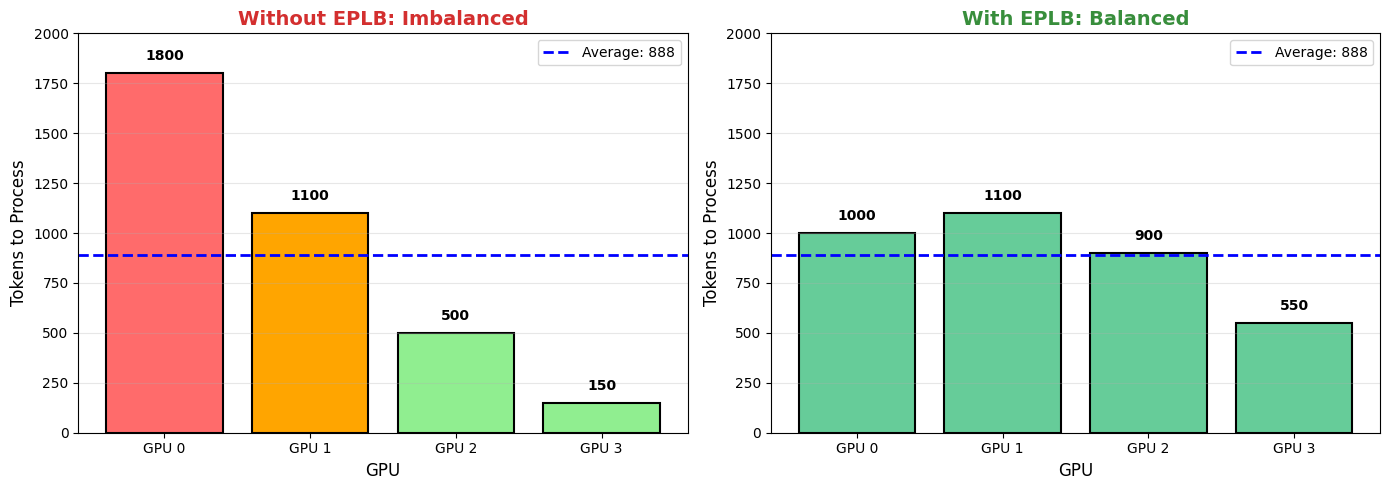


🎯 Key Takeaway:
   EPLB monitors expert popularity and redistributes them across GPUs
   to prevent bottlenecks and maximize throughput!
   Remember: Experts still process the SAME tokens, just on different GPUs!


In [1]:
# EPLB Load Balancing Demonstration
import matplotlib.pyplot as plt
import numpy as np

# Scenario: 8 experts, 4 GPUs
# Each expert has different popularity (tokens to process)
expert_popularity = np.array([1000, 800, 600, 500, 300, 200, 100, 50])

print("=" * 70)
print("EPLB Load Balancing Demonstration")
print("=" * 70)
print("\n📊 Expert Popularity (tokens each expert needs to process):")
for i, tokens in enumerate(expert_popularity):
    bar = '█' * (tokens // 100)
    print(f"  Expert {i}: {bar} {tokens} tokens")

# Without EPLB: naive assignment (2 experts per GPU)
print("\n\n❌ WITHOUT EPLB (Naive Assignment: 2 experts per GPU)")
print("-" * 70)
naive_assignment = {
    0: [0, 1],  # GPU 0 gets Expert 0, 1
    1: [2, 3],  # GPU 1 gets Expert 2, 3
    2: [4, 5],  # GPU 2 gets Expert 4, 5
    3: [6, 7]   # GPU 3 gets Expert 6, 7
}

naive_loads = []
for gpu_id, expert_ids in naive_assignment.items():
    load = sum(expert_popularity[e] for e in expert_ids)
    naive_loads.append(load)
    expert_str = ', '.join([f"E{e}" for e in expert_ids])
    print(f"GPU {gpu_id}: [{expert_str}] → {load} tokens")

print(f"\n⚠️  Problem:")
print(f"    • GPU 0 is overloaded: {max(naive_loads)} tokens")
print(f"    • GPU 3 is mostly idle: {min(naive_loads)} tokens")
print(f"    • Throughput limited by slowest GPU!")

# With EPLB: balanced assignment
print("\n\n✅ WITH EPLB (Smart Rebalancing)")
print("-" * 70)
eplb_assignment = {
    0: [0],        # Most popular expert gets its own GPU
    1: [1, 4],     # Balance: 800 + 300 = 1100
    2: [2, 5, 6],  # Balance: 600 + 200 + 100 = 900
    3: [3, 7]      # Balance: 500 + 50 = 550
}

eplb_loads = []
for gpu_id, expert_ids in eplb_assignment.items():
    load = sum(expert_popularity[e] for e in expert_ids)
    eplb_loads.append(load)
    expert_str = ', '.join([f"E{e}" for e in expert_ids])
    print(f"GPU {gpu_id}: [{expert_str}] → {load} tokens")

print(f"\n✅ Result:")
print(f"    • All GPUs balanced (~{np.mean(eplb_loads):.0f} tokens average)")
print(f"    • Max load reduced from {max(naive_loads)} to {max(eplb_loads)}")
print(f"    • Throughput improvement: ~{max(naive_loads)/max(eplb_loads):.1f}x faster!")

# Visualize the difference
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Without EPLB
colors_naive = ['#ff6b6b' if load > 1500 else '#ffa500' if load > 1000 else '#90EE90' for load in naive_loads]
bars1 = ax1.bar(range(4), naive_loads, color=colors_naive, edgecolor='black', linewidth=1.5)
ax1.axhline(y=np.mean(naive_loads), color='blue', linestyle='--', linewidth=2, label=f'Average: {np.mean(naive_loads):.0f}')
ax1.set_title('Without EPLB: Imbalanced', fontsize=14, fontweight='bold', color='#d32f2f')
ax1.set_xlabel('GPU', fontsize=12)
ax1.set_ylabel('Tokens to Process', fontsize=12)
ax1.set_xticks(range(4))
ax1.set_xticklabels([f'GPU {i}' for i in range(4)])
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 2000)

# Add load labels on bars
for i, (bar, load) in enumerate(zip(bars1, naive_loads)):
    ax1.text(bar.get_x() + bar.get_width()/2, load + 50, f'{load}', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# With EPLB
bars2 = ax2.bar(range(4), eplb_loads, color='#66cc99', edgecolor='black', linewidth=1.5)
ax2.axhline(y=np.mean(eplb_loads), color='blue', linestyle='--', linewidth=2, label=f'Average: {np.mean(eplb_loads):.0f}')
ax2.set_title('With EPLB: Balanced', fontsize=14, fontweight='bold', color='#388e3c')
ax2.set_xlabel('GPU', fontsize=12)
ax2.set_ylabel('Tokens to Process', fontsize=12)
ax2.set_xticks(range(4))
ax2.set_xticklabels([f'GPU {i}' for i in range(4)])
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 2000)

# Add load labels on bars
for i, (bar, load) in enumerate(zip(bars2, eplb_loads)):
    ax2.text(bar.get_x() + bar.get_width()/2, load + 50, f'{load}', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("🎯 Key Takeaway:")
print("   EPLB monitors expert popularity and redistributes them across GPUs")
print("   to prevent bottlenecks and maximize throughput!")
print("   Remember: Experts still process the SAME tokens, just on different GPUs!")
print("=" * 70)

## How WideEP Works in Dynamo

Example Dynamo configuration (SGLang backend) for WideEP:

```yaml
backend: sglang
model: deepseek-r1
parallelism:
  type: wide-ep
  num_experts: 64
  active_experts: 2
  routing: topk
  comms: alltoall
hardware:
  cluster: GB200
  gpus_per_node: 8
  interconnect: NVLINK
```

**Key points:**
- Tokens are routed across nodes via high-speed interconnects.
- Each expert processes its share to keep memory and compute balanced.
- Dynamic padding ensures even per-batch load.

---

## Backend Support in Dynamo

| Backend | EP Support | Notes |
|---------|------------|-------|
| SGLang | ✅ WideEP, EPLB | Full support for DeepSeek models |
| TensorRT-LLM | ✅ via `moe_expert_parallel_size` | Works with Dynamo runtime; strong FP8/KV optimizations |
| vLLM | ⚠️ Basic MoE only | EP integration planned (router layer) |

Example TensorRT-LLM (conceptual) config:
```json
{
  "backend": "tensorrt-llm",
  "parallelism": {
    "type": "wide-ep",
    "moe_ep_size": 8,
    "enable_dynamic_routing": true
  },
  "hardware": {
    "gpus": 64,
    "interconnect": "NVLINK",
    "cluster": "GB200"
  }
}
```

---

## 7. Hands-on Exercises

### Exercise 1 — WideEP Routing Simulation

Simulate how tokens get assigned to top-k experts.

Run the cell below and observe randomized token→experts assignments.

In [2]:
# Exercise 1: token → experts (top-k) routing simulation
import random

experts = [f"E{i}" for i in range(8)]
tokens = [f"T{i}" for i in range(16)]

def route(tokens, experts, topk=2):
    routing = {}
    for t in tokens:
        routing[t] = random.sample(experts, topk)
    return routing

routing = route(tokens, experts)
for t, e in routing.items():
    print(f"{t} → {e}")

T0 → ['E7', 'E4']
T1 → ['E3', 'E2']
T2 → ['E2', 'E0']
T3 → ['E2', 'E5']
T4 → ['E5', 'E2']
T5 → ['E6', 'E7']
T6 → ['E2', 'E5']
T7 → ['E2', 'E5']
T8 → ['E5', 'E6']
T9 → ['E7', 'E0']
T10 → ['E1', 'E0']
T11 → ['E7', 'E1']
T12 → ['E2', 'E4']
T13 → ['E1', 'E5']
T14 → ['E2', 'E4']
T15 → ['E2', 'E4']


### Exercise 2 — Throughput Comparison Chart

Visualize relative throughput improvements from different strategies.

**⚠️ Note**: The values below are **illustrative examples only** to demonstrate the concept. Actual performance will vary significantly based on your hardware, model size, workload characteristics, and configuration. Always run your own benchmarks to measure real performance!

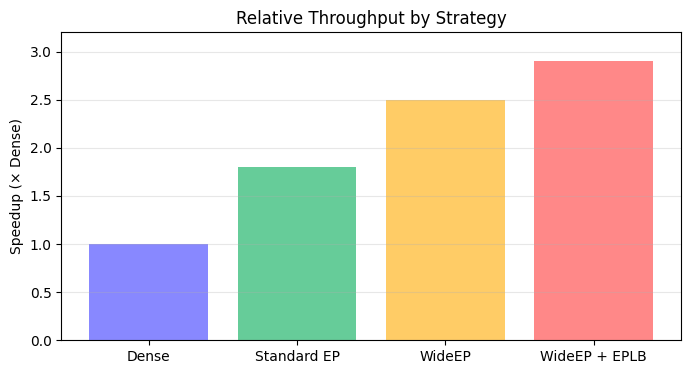

In [ ]:
# Exercise 2: simple bar chart of relative throughput (ILLUSTRATIVE VALUES)
import matplotlib.pyplot as plt

x = ["Dense", "Standard EP", "WideEP", "WideEP + EPLB"]
y = [1.0, 1.8, 2.5, 2.9]  # Illustrative values - NOT actual benchmarks!

plt.figure(figsize=(8,4))
plt.bar(x, y, color=["#8888ff", "#66cc99", "#ffcc66", "#ff8888"])
plt.title("Relative Throughput by Strategy (Illustrative)")
plt.ylabel("Speedup (× Dense)")
plt.ylim(0, 3.2)
plt.grid(axis='y', alpha=0.3)
plt.text(0.5, 3.0, 'Values are illustrative only!', 
         ha='center', fontsize=10, style='italic', color='red')
plt.show()

## 8. Advanced: Large-Scale Wide-EP on GB200 NVL72

Drawing from NVIDIA's recent technical deep-dive, Wide Expert Parallelism (Wide-EP) on GB200 NVL72 emphasizes scaling MoE inference efficiently across many GPUs:

- **Large-scale EP**: distributing experts across ≥8 GPUs to increase aggregate bandwidth and utilization.
- **Reduce weight-loading pressure**: fewer experts per GPU → less frequent weight swaps → better GroupGEMM efficiency.
- **Improve arithmetic intensity**: tokens routed to the same expert are batched into GroupGEMMs for higher FLOPs/byte.
- **NVL72 interconnect**: leverages a coherent NVLink domain (~130 TB/s aggregate) to offset all-to-all overhead during decode.
- **Custom NCCL kernels**: handle non-static communication sizes and integrate with CUDA graphs at rack scale.
- **EPLB modes**: static (precomputed mappings) and online (runtime redistribution), with containerized weight updates between forward passes.
- **Observed outcome**: up to ~1.8× higher per-GPU throughput vs smaller EP configurations on NVL72.

Reference: [Scaling Large MoE Models with Wide Expert Parallelism on NVL72](https://developer.nvidia.com/blog/scaling-large-moe-models-with-wide-expert-parallelism-on-nvl72-rack-scale-systems/?utm_source=chatgpt.com)

---

### GroupGEMM and Weight-Loading Intuition

MoE layers pack tokens per expert into a single GroupGEMM for efficiency. Wide-EP reduces the number of experts per GPU, easing weight-loading pressure and improving reuse inside the GroupGEMM kernel.

### Figure 4: GroupGEMM Token Routing

![Figure 4: GroupGEMM](images/figure2_groupgemm_token_routing.webp)

*Tokens routed to the same expert are packed together and processed with a single fused GroupGEMM kernel for efficient MoE inference.*

The toy simulation below shows:
- How expert popularity drives packed group sizes
- How increasing EP rank reduces experts-per-GPU (proxy for fewer weights to juggle)

Reference: [NVIDIA NVL72 Wide-EP blog](https://developer.nvidia.com/blog/scaling-large-moe-models-with-wide-expert-parallelism-on-nvl72-rack-scale-systems/?utm_source=chatgpt.com)

---

Wide-EP: Distributing 256 Experts Across GPUs

DeepSeek-V3 has 256 experts. How many experts per GPU?

Small EP
(8 GPUs)   : 32 experts/GPU
Medium EP
(16 GPUs) : 16 experts/GPU
Wide EP
(32 GPUs)   :  8 experts/GPU
Very Wide EP
(64 GPUs):  4 experts/GPU

Key Insight:
  • Fewer experts per GPU = Less weight-loading pressure
  • Wide-EP (32-64 GPUs) enables efficient GroupGEMM operations
  • Trade-off: More GPUs needed, but higher throughput per GPU


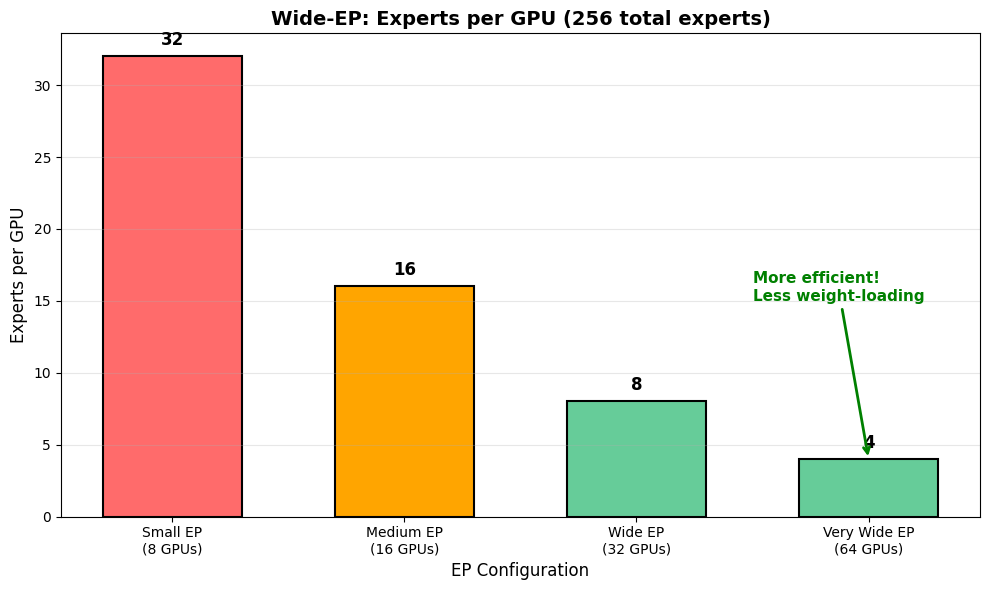

In [4]:
# Wide-EP: Reducing Experts per GPU
import matplotlib.pyplot as plt
import numpy as np

# Simple visualization: How Wide-EP distributes 256 experts
TOTAL_EXPERTS = 256
ep_configs = [
    ("Small EP\n(8 GPUs)", 8),
    ("Medium EP\n(16 GPUs)", 16),
    ("Wide EP\n(32 GPUs)", 32),
    ("Very Wide EP\n(64 GPUs)", 64)
]

print("=" * 70)
print("Wide-EP: Distributing 256 Experts Across GPUs")
print("=" * 70)
print("\nDeepSeek-V3 has 256 experts. How many experts per GPU?\n")

labels = []
experts_per_gpu = []
colors = []

for label, num_gpus in ep_configs:
    epg = TOTAL_EXPERTS // num_gpus
    experts_per_gpu.append(epg)
    labels.append(label)
    
    # Color code: red for many experts/GPU, green for few
    if epg >= 20:
        colors.append('#ff6b6b')  # Red - too many!
    elif epg >= 10:
        colors.append('#ffa500')  # Orange - moderate
    else:
        colors.append('#66cc99')  # Green - good!
    
    print(f"{label:20s}: {epg:2d} experts/GPU")

print("\n" + "=" * 70)
print("Key Insight:")
print("  • Fewer experts per GPU = Less weight-loading pressure")
print("  • Wide-EP (32-64 GPUs) enables efficient GroupGEMM operations")
print("  • Trade-off: More GPUs needed, but higher throughput per GPU")
print("=" * 70)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(range(len(labels)), experts_per_gpu, color=colors, 
              edgecolor='black', linewidth=1.5, width=0.6)

ax.set_title('Wide-EP: Experts per GPU (256 total experts)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('EP Configuration', fontsize=12)
ax.set_ylabel('Experts per GPU', fontsize=12)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, fontsize=10)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, experts_per_gpu):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., height + 0.5,
            f'{value}', ha='center', va='bottom', 
            fontweight='bold', fontsize=12)

# Add annotation
ax.annotate('More efficient!\nLess weight-loading', 
            xy=(3, experts_per_gpu[3]), 
            xytext=(2.5, 15),
            arrowprops=dict(arrowstyle='->', color='green', lw=2),
            fontsize=11, color='green', fontweight='bold')

plt.tight_layout()
plt.show()

### When to use Wide-EP (NVL72 perspective)

- **Model scale**: Larger MoE (e.g., DeepSeek-R1 with many experts) benefits most.
- **Latency-constrained throughput**: Improves tokens/sec/GPU at similar latency targets.
- **Hardware**: High-bandwidth interconnect (e.g., NVL72 coherent NVLink) is key to hide all-to-all.
- **Scheduling**: Combine disaggregated serving + Wide-EP for best results.

**Dynamo + TensorRT-LLM synergy:**
- **Dynamo**: orchestrates disaggregated prefill/decode, SLA-aware scaling, routing.
- **TensorRT-LLM Wide-EP**: executes expert-parallel MoE with optimized kernels, FP8/graphs, and EPLB.

### Figure 5: EP Throughput Comparison

![Figure 5: Throughput](images/figure5_ep_throughput_comparison.webp)

*Large-scale Expert Parallelism (EP) rank 32 delivers up to 1.8x higher output token throughput per GPU compared to small EP rank 8 at 100 tokens/sec per user. Both configurations leverage disaggregated serving and multi-token prediction (MTP).*

Reference: [NVIDIA NVL72 Wide-EP blog](https://developer.nvidia.com/blog/scaling-large-moe-models-with-wide-expert-parallelism-on-nvl72-rack-scale-systems/?utm_source=chatgpt.com)

---

## Summary

Congratulations! You've completed Lab 3.1. You now understand:

- **DP/TP/PP/SP**: apply to all models; solve memory/compute distribution differently.
- **EP**: MoE-only; route tokens to a small set of experts per token.
- **Dynamo**: supports Standard EP, WideEP, DeepEP, and dynamic EPLB via backends.
- **WideEP + EPLB**: production-proven for scaling throughput and balancing load.
- **NVL72 insights**: Large-scale EP with high-bandwidth interconnects delivers up to 1.8× per-GPU throughput gains.

### 🚀 Next Steps

Ready to deploy these concepts in production? Continue to:

**Lab 3.2: Wide EP Production Deployment** (`lab3.2-wide-ep-deployment.ipynb`)

In Lab 3.2, you'll learn:
- Kubernetes deployment with Dynamo Operator
- Multi-node SGLang deployment with EPLB
- TensorRT-LLM Wide EP configuration
- Monitoring, troubleshooting, and performance tuning
- Production best practices

---

## 9. Further Reading

### MoE Architecture and Comparisons
- [The Big LLM Architecture Comparison (Sebastian Raschka)](https://magazine.sebastianraschka.com/p/the-big-llm-architecture-comparison) - Detailed comparison of DeepSeek-V3, Qwen3, and other MoE architectures

### Expert Parallelism Deployment
- [Scaling Large MoE Models with Wide Expert Parallelism on NVL72](https://developer.nvidia.com/blog/scaling-large-moe-models-with-wide-expert-parallelism-on-nvl72-rack-scale-systems/?utm_source=chatgpt.com) - NVIDIA's technical deep-dive on Wide-EP deployment strategies
- [TensorRT-LLM Wide-EP Examples](https://github.com/NVIDIA/TensorRT-LLM/tree/main/examples/wide_ep)

### Dynamo and Backends
- [NVIDIA Dynamo Documentation](https://github.com/NVIDIA/Dynamo)
- [SGLang Documentation](https://github.com/sgl-project/sglang)